In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import tqdm  # For progress display
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Choose architecture: 'resnet50' or 'vgg16'
architecture = 'resnet50'  # or 'vgg16'

# Step 1: Load CIFAR-10 dataset with transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
])

# Load CIFAR-10 dataset
cifar10_dataset = datasets.ImageFolder(root='imgs', transform=transform)

# Step 2: Load pretrained model and modify it to remove the final layer

# Define feature extractor classes
class FeatureExtractorResNet(nn.Module):
    def __init__(self):
        super(FeatureExtractorResNet, self).__init__()
        model = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(model.children())[:-1])  # Exclude the last FC layer

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 2048)
        return x

class FeatureExtractorVGG(nn.Module):
    def __init__(self):
        super(FeatureExtractorVGG, self).__init__()
        model = models.vgg16(pretrained=True)
        self.features = model.features
        self.avgpool = model.avgpool  # AdaptiveAvgPool2d
        # Include the classifier layers up to the second last layer
        self.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the model based on the architecture
if architecture == 'resnet50':
    model = FeatureExtractorResNet()
elif architecture == 'vgg16':
    model = FeatureExtractorVGG()

model = model.to(device)
model.eval()

# Step 3: Define DataLoader with batch processing
batch_size = 64  # Adjust batch size based on GPU memory
data_loader = DataLoader(cifar10_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Batch feature extraction function
def extract_features_batch(dataloader, model):
    features_db = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for images, _ in tqdm.tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)  # Move batch of images to device
            batch_features = model(images)  # Get features for batch
            batch_features = batch_features.cpu().numpy()  # Move to CPU and convert to numpy
            features_db.append(batch_features)

    # Stack all features into a single array
    return np.vstack(features_db)

# Extract features for all CIFAR-10 images in batches
# features_db = extract_features_batch(data_loader, model)

# Save features if needed
# np.save('features_db.npy', features_db)

# Or load pre-extracted features
# features_db = np.load('features_db.npy')

# Step 4: Define function to find most similar images using cosine similarity
def find_similar_images(query_image_path, features_db, top_n=5):
    # Load and preprocess the query image
    query_image = Image.open(query_image_path).convert('RGB')
    query_image = transform(query_image)
    query_image = query_image.to(device)  # Move query image to device
    query_features = extract_features(query_image.unsqueeze(0))  # Extract features for query image

    # Compute cosine similarities
    similarities = cosine_similarity([query_features], features_db)[0]

    # Get indices of most similar images
    most_similar_indices = similarities.argsort()[-top_n:][::-1]

    # Retrieve most similar images and similarity scores
    similar_images = [(cifar10_dataset.imgs[idx], similarities[idx]) for idx in most_similar_indices]
    return similar_images

# Helper function to extract features for a single image
def extract_features(image):
    with torch.no_grad():
        features = model(image)
        features = features.cpu().numpy().flatten()  # Move to CPU and convert to numpy
        return features

# Step 5: Test with a query image
query_image_path = 'istockphoto-155439315-612x612.jpg'   # Replace with the actual path to the user-provided image
# query_image_path = 'istockphoto-1066158704-612x612.jpg'
similar_images = find_similar_images(query_image_path, features_db)



In [2]:
features_db = np.load("features_resnet50.npy")

In [246]:
np.save("features_vgg16.npy",features_db)

Rank 1, Similarity: 0.6817123293876648


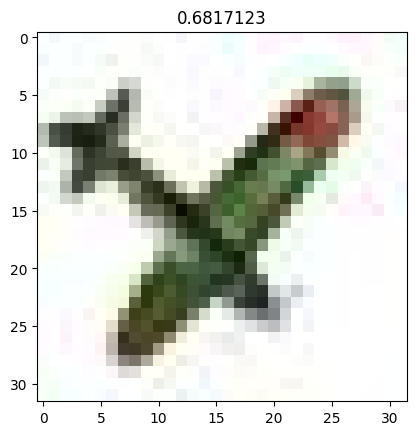

Rank 2, Similarity: 0.6752487421035767


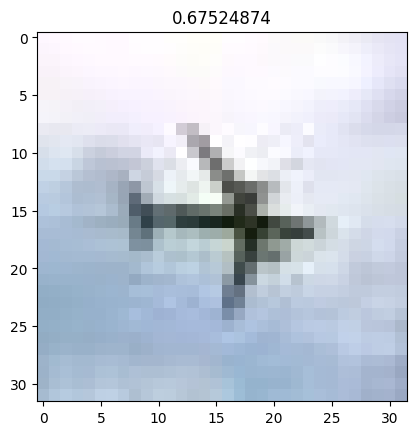

Rank 3, Similarity: 0.6744174957275391


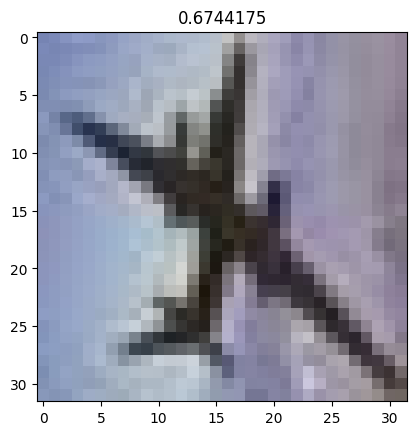

Rank 4, Similarity: 0.6730771660804749


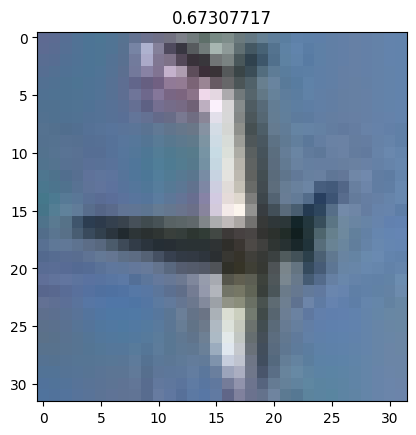

Rank 5, Similarity: 0.6710634231567383


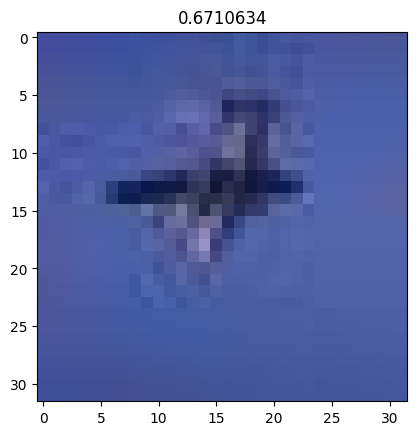

In [5]:

query_image_path = 'istockphoto-155439315-612x612.jpg'  # Replace with the actual path to the user-provided image
similar_images = find_similar_images(query_image_path, features_db)

# # # Display results
for i, (image_data, similarity) in enumerate(similar_images):
    print(f"Rank {i+1}, Similarity: {similarity}")

     # Convert CIFAR-10 image array to PIL image and display
    original_image = Image.open(image_data[0])
    plt.imshow(original_image)
    plt.title(similarity)
    plt.show()

In [70]:
# Load and preprocess the query image
query_image_path = 'istockphoto-155439315-612x612.jpg'
query_image = Image.open(query_image_path).convert('RGB')
query_image = transform(query_image)
query_image = query_image.to(device)  # Move query image to device
query_features = extract_features(query_image.unsqueeze(0))  # Extract features for query image

# Compute cosine similarities
similarities = cosine_similarity([query_features], features_db)[0]

# Get indices of most similar images
most_similar_indices = similarities.argsort()[-2:][::-1]

# Retrieve most similar images path and similarity scores
similar_images = [(cifar10_dataset.imgs[idx], similarities[idx]) for idx in most_similar_indices]

node_0 = [query_image_path,similar_images[0][0][0],similar_images[1][0][0]]
weight_0 = [similar_images[0][1],similar_images[1][1]]

query_image_path = node_0[1]
query_image = Image.open(query_image_path).convert('RGB')
query_image = transform(query_image)
query_image = query_image.to(device)  # Move query image to device
query_features = extract_features(query_image.unsqueeze(0))  # Extract features for query image

# Compute cosine similarities
similarities = cosine_similarity([query_features], features_db)[0]

# Get indices of most similar images
most_similar_indices = similarities.argsort()[-3:][::-1]

# Retrieve most similar images path and similarity scores
similar_images = [(cifar10_dataset.imgs[idx], similarities[idx]) for idx in most_similar_indices]

node_1_1 = [query_image_path,similar_images[1][0][0],similar_images[2][0][0]]
weight_1_1 = [similar_images[1][1],similar_images[2][1]]

query_image_path = node_0[2]
query_image = Image.open(query_image_path).convert('RGB')
query_image = transform(query_image)
query_image = query_image.to(device)  # Move query image to device
query_features = extract_features(query_image.unsqueeze(0))  # Extract features for query image

# Compute cosine similarities
similarities = cosine_similarity([query_features], features_db)[0]

# Get indices of most similar images
most_similar_indices = similarities.argsort()[-3:][::-1]

# Retrieve most similar images path and similarity scores
similar_images = [(cifar10_dataset.imgs[idx], similarities[idx]) for idx in most_similar_indices]

node_1_2 = [query_image_path,similar_images[1][0][0],similar_images[2][0][0]]
weight_1_2 = [similar_images[1][1],similar_images[2][1]]

In [71]:
similar_images[0][1]

0.6817123

In [149]:
import numpy as np
from PIL import Image
import networkx as nx

# Function to get similar images
def get_similar_images(query_image_path, N):
    # Load and preprocess the query image
    query_image = Image.open(query_image_path).convert('RGB')
    query_image = transform(query_image)
    query_image = query_image.to(device)  # Move query image to device
    query_features = extract_features(query_image.unsqueeze(0))  # Extract features for query image

    # Compute cosine similarities
    similarities = cosine_similarity([query_features], features_db)[0]

    # Sort indices in descending order of similarity
    sorted_indices = similarities.argsort()[::-1]

    # Exclude the query image if it's in the dataset
    query_features_np = query_features.flatten()
    features_db_np = features_db

    distances = np.linalg.norm(features_db_np - query_features_np, axis=1)
    min_distance_index = np.argmin(distances)
    if distances[min_distance_index] < 1e-6:
        # Query image is in the database
        sorted_indices = sorted_indices[sorted_indices != min_distance_index]

    # Now get the top N similar images
    most_similar_indices = sorted_indices[:N]

    # Retrieve most similar images path and similarity scores
    similar_images = [(cifar10_dataset.imgs[idx], similarities[idx]) for idx in most_similar_indices]
    return similar_images

# Function to build the similarity graph
# Function to build the similarity graph with normalized edge weights
def build_similarity_graph(query_image_path, depth=2, N=2):
    G = nx.Graph()
    visited = set()
    queue = [(query_image_path, 0)]  # (image_path, current_depth)
    while queue:
        current_image_path, current_depth = queue.pop(0)  # BFS
        if current_depth >= depth:
            continue
        if current_image_path in visited:
            continue
        visited.add(current_image_path)

        similar_images = get_similar_images(current_image_path, N+1)  # +1 to account for possible query image exclusion

        # Exclude the current image from similar_images
        similar_images = [sim_img for sim_img in similar_images if sim_img[0][0] != current_image_path]

        if not similar_images:
            continue  # Skip if no similar images found

        # Compute total similarity for normalization
        total_similarity = sum([similar_image[1] for similar_image in similar_images])

        # Normalize similarities and add edges
        for similar_image in similar_images:
            normalized_similarity = similar_image[1] / total_similarity  # Normalize similarity
            similar_image_path = similar_image[0][0]
            # Add edge to the graph with normalized weight
            G.add_edge(current_image_path, similar_image_path, weight=normalized_similarity)
            queue.append((similar_image_path, current_depth + 1))
    return G


# Usage
query_image_path = 'istockphoto-155439315-612x612.jpg'
G = build_similarity_graph(query_image_path, depth=3, N=10)

# Now G contains your graph, and you can proceed with the diffusion process


In [173]:
import numpy as np
from collections import Counter

def random_walk_diffusion(G, start_node, num_steps):
    current_node = start_node
    path = [current_node]
    for _ in range(num_steps):
        neighbors = list(G.neighbors(current_node))
        if not neighbors:
            break
        # Exclude the start node after leaving it
        if current_node != start_node:
            neighbors = [neighbor for neighbor in neighbors if neighbor != start_node]
            if not neighbors:
                break  # No other neighbors to move to
        weights = np.array([G[current_node][neighbor]['weight'] for neighbor in neighbors])
        probabilities = weights / weights.sum()
        current_node = np.random.choice(neighbors, p=probabilities)
        path.append(current_node)
    return path

# Example usage:
start_node = query_image_path
path = random_walk_diffusion(G, start_node, num_steps=100)
visit_counts = Counter(path)
print("Random walk path:", path)



Random walk path: ['istockphoto-155439315-612x612.jpg', 'imgs\\0\\3445.jpg', 'imgs\\0\\5460.jpg', 'imgs\\0\\5223.jpg', 'imgs\\0\\9413.jpg', 'imgs\\1\\1706.jpg', 'imgs\\0\\9413.jpg', 'imgs\\8\\4649.jpg', 'imgs\\0\\9413.jpg', 'imgs\\0\\1310.jpg', 'imgs\\0\\3445.jpg', 'imgs\\0\\5460.jpg', 'imgs\\0\\5223.jpg', 'imgs\\0\\1310.jpg', 'imgs\\0\\5460.jpg', 'imgs\\0\\423.jpg', 'imgs\\0\\5460.jpg', 'imgs\\0\\6885.jpg', 'imgs\\0\\5460.jpg', 'imgs\\0\\9413.jpg', 'imgs\\0\\9271.jpg', 'imgs\\0\\6057.jpg', 'imgs\\0\\3754.jpg', 'imgs\\0\\298.jpg', 'imgs\\0\\3754.jpg', 'imgs\\0\\298.jpg', 'imgs\\0\\854.jpg', 'imgs\\0\\298.jpg', 'imgs\\0\\6508.jpg', 'imgs\\0\\9473.jpg', 'imgs\\0\\6508.jpg', 'imgs\\0\\3499.jpg', 'imgs\\0\\2468.jpg', 'imgs\\0\\3248.jpg', 'imgs\\0\\2468.jpg', 'imgs\\0\\4419.jpg', 'imgs\\0\\3475.jpg', 'imgs\\0\\6644.jpg', 'imgs\\0\\3248.jpg', 'imgs\\2\\4434.jpg', 'imgs\\0\\3024.jpg', 'imgs\\0\\3499.jpg', 'imgs\\0\\6304.jpg', 'imgs\\0\\1973.jpg', 'imgs\\0\\9182.jpg', 'imgs\\0\\1973.jpg', 'img

In [175]:
visit_counts

Counter({'imgs\\0\\298.jpg': 7,
         'imgs\\0\\5460.jpg': 5,
         'imgs\\0\\9413.jpg': 4,
         'imgs\\0\\6508.jpg': 4,
         'imgs\\0\\3499.jpg': 4,
         'imgs\\0\\3024.jpg': 4,
         'imgs\\0\\3248.jpg': 3,
         'imgs\\0\\4419.jpg': 3,
         'imgs\\0\\6304.jpg': 3,
         'imgs\\0\\1973.jpg': 3,
         'imgs\\0\\3445.jpg': 2,
         'imgs\\0\\5223.jpg': 2,
         'imgs\\0\\1310.jpg': 2,
         'imgs\\0\\3754.jpg': 2,
         'imgs\\0\\9473.jpg': 2,
         'imgs\\0\\2468.jpg': 2,
         'imgs\\0\\3475.jpg': 2,
         'imgs\\0\\6644.jpg': 2,
         'imgs\\2\\4434.jpg': 2,
         'imgs\\0\\98.jpg': 2,
         'imgs\\0\\6437.jpg': 2,
         'imgs\\0\\2095.jpg': 2,
         'imgs\\0\\1183.jpg': 2,
         'imgs\\3\\7979.jpg': 2,
         'imgs\\0\\5722.jpg': 2,
         'imgs\\0\\1748.jpg': 2,
         'imgs\\0\\9512.jpg': 2,
         'imgs\\0\\6347.jpg': 2,
         'istockphoto-155439315-612x612.jpg': 1,
         'imgs\\1\\1706.jpg': 

In [174]:
# Get the 5 nodes with the highest visit counts
top_5_nodes = [node for node, count in visit_counts.most_common(5)]
print("Top 5 most visited nodes:", top_5_nodes)


Top 5 most visited nodes: ['imgs\\0\\298.jpg', 'imgs\\0\\5460.jpg', 'imgs\\0\\9413.jpg', 'imgs\\0\\6508.jpg', 'imgs\\0\\3499.jpg']


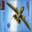

In [177]:
Image.open(top_5_nodes[0])

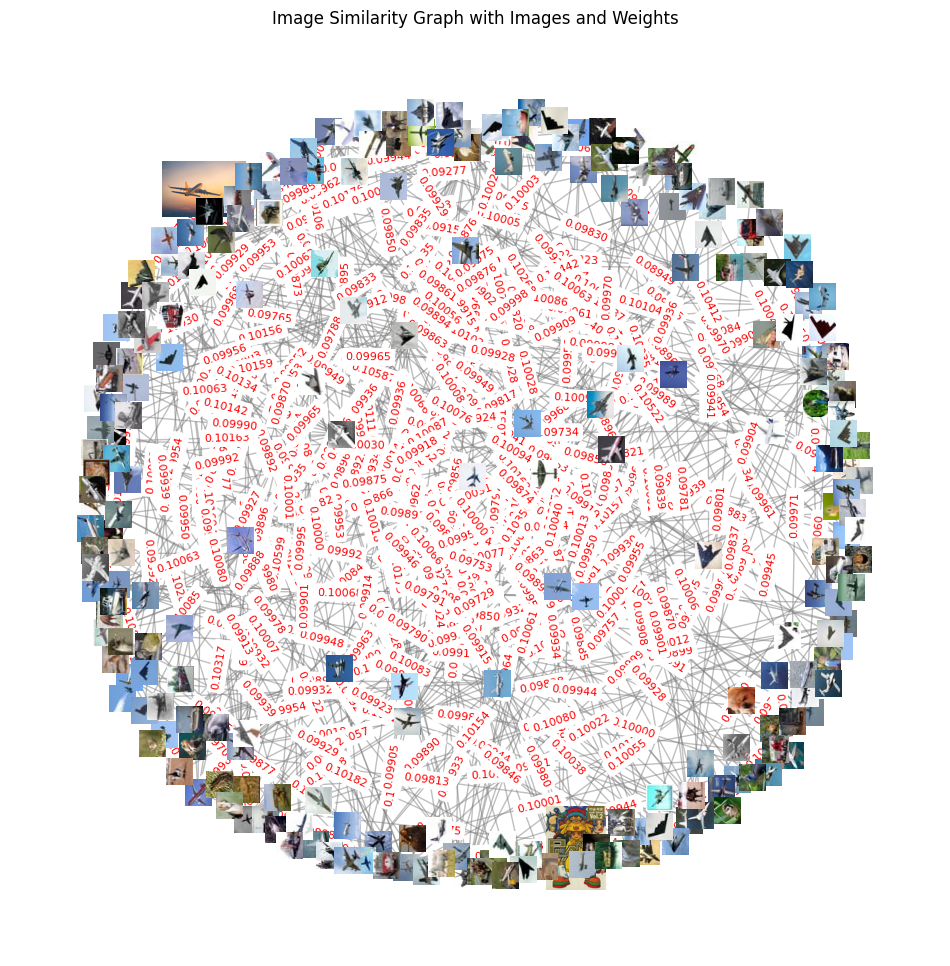

In [151]:
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def visualize_graph_with_images_and_weights(G):
    pos = nx.spring_layout(G, k=0.8)
    plt.figure(figsize=(12, 12))
    ax = plt.gca()

    # Draw edges with constant width
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=1)

    # For each node, place the image at its position
    for node in G.nodes():
        x, y = pos[node]
        # Load and resize the image
        try:
            img = Image.open(node).convert('RGB')
        except FileNotFoundError:
            print(f"Image not found: {node}")
            continue
        img.thumbnail((100, 100), Image.LANCZOS)
        # Create an OffsetImage
        imagebox = OffsetImage(img)
        # Adjust the zoom level if needed
        imagebox = OffsetImage(img, zoom=0.6)
        # Create an AnnotationBbox and add it to the plot
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

    # Prepare edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    # Format the weights to have up to 2 decimal places
    formatted_edge_labels = {edge: f"{weight:.5f}" for edge, weight in edge_labels.items()}

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels, font_color='red', font_size=8)

    # Remove axes and display the plot
    plt.axis('off')
    plt.title("Image Similarity Graph with Images and Weights")
    plt.show()

# Call the function to visualize the graph
visualize_graph_with_images_and_weights(G)


In [77]:
node_0

['istockphoto-155439315-612x612.jpg', 'imgs\\0\\98.jpg', 'imgs\\0\\4419.jpg']

In [78]:
node_1_1

['imgs\\0\\98.jpg', 'imgs\\0\\3927.jpg', 'imgs\\0\\2095.jpg']

In [79]:
node_1_2

['imgs\\0\\4419.jpg', 'imgs\\0\\2095.jpg', 'imgs\\0\\6824.jpg']

In [80]:
weight_0

[0.6817123, 0.67524874]

In [81]:
weight_1_1

[0.91138935, 0.87628525]

In [ ]:
weight_1_2

Rank 1, Similarity: 0.6817123293876648


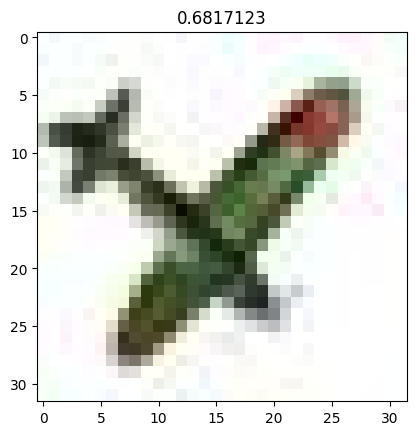

Rank 2, Similarity: 0.6752487421035767


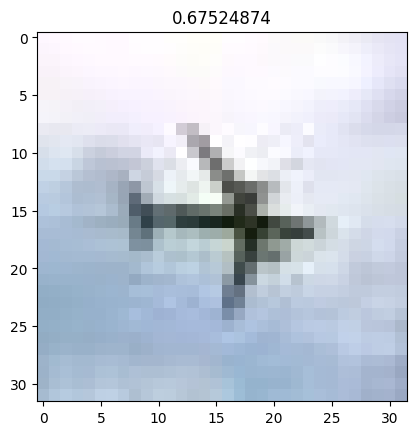

In [33]:
for i, (image_data, similarity) in enumerate(similar_images):
    print(f"Rank {i+1}, Similarity: {similarity}")

     # Convert CIFAR-10 image array to PIL image and display
    original_image = Image.open(image_data[0])
    plt.imshow(original_image)
    plt.title(similarity)
    plt.show()

TypeError: expected str, bytes or os.PathLike object, not tuple

In [ ]:
aa = Image.open('C:/Users/Stefan/Downloads/Usogui v01_jp2/Usogui v01_0000.jp2')
aa.save('imgs/11/000.jpg')